In [1]:
import plotly.graph_objs as go
import pandas as pd
from matchms.importing import load_from_msp
from matchms.logging_functions import set_matchms_logger_level

from utils import is_spectrum_for_compound, append_classes, load_spectra_metadata, normalize_df
from plotting import scatterplot_matplotlib

set_matchms_logger_level('ERROR')

/tmp/ipykernel_28943/2935852247.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
matchms_scores = pd.read_csv("../data/output_matching/matchms/matchms_tol_0.0035_1%I_all_peaks_with_0s_only_matching.tsv", sep="\t")
matchms_scores.rename(columns={'CosineHungarian_0.0035_0.0_1.0_scores': 'scores'}, inplace=True)
matchms_scores.rename(columns={'CosineHungarian_0.0035_0.0_1.0_matches': 'matches'}, inplace=True)

In [3]:
_ , spectra_metadata, _ = load_spectra_metadata("../data/filtered/simulated_matchms_filter_1%I_all_peaks.msp", 'query')
_ , reference_spectra_metadata, _ = load_spectra_metadata("../data/experimental/RECETOX_GC-EI_MS_20201028.msp", 'reference')

In [4]:
merged = matchms_scores.merge(spectra_metadata, on="query", how="inner")
merged.rename(columns={'num_peaks': 'n_peaks_query'}, inplace=True)

merged = merged.merge(reference_spectra_metadata, on="reference", how="inner")
merged.rename(columns={'num_peaks': 'n_peaks_reference'}, inplace=True)

numeric_columns = ['matches', 'n_peaks_query', 'n_peaks_reference']
merged[numeric_columns] = merged[numeric_columns].apply(pd.to_numeric, errors='coerce')

merged['FractionQuery'] = merged['matches'] / merged['n_peaks_query']
merged['FractionReference'] = merged['matches'] / merged['n_peaks_reference']

merged = append_classes(merged, "query")

In [ ]:
# Create a scatter plot
def scatterplot_plotly(df, title):
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df['scores'],
        y=df['matches'],
        mode='markers',
        marker=dict(
            size= (df['FractionQuery'] * 100),  # Adjust the size scaling factor as needed
            sizeref=5,
            color=df['FractionReference'] * 100,
            colorscale='Viridis',  # change the colorscale as needed
            colorbar=dict(title='Reference Matched %'),
            cmin=0,  # Set the minimum color limit
            cmax=100,  # Set the maximum color limit
            opacity=0.5
        ),
        #text=df['reference'],
        textposition='middle right',
        # textposition=['top right' if i % 2 == 0 else 'bottom right' for i in range(len(df))],  # Make text positions alternating
        name='Matched Ions'
    ))
    fig.update_layout(
        xaxis_title='Score',
        yaxis_title='Matches',
        title_text=title,
        width=800,
        height=600
    )
    fig.show()
    return fig

In [ ]:
# Create a scatter plot
def scatterplot_plotly_with_legends(df, title):
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df['scores'],
        y=df['matches'],
        mode='markers+text',
        marker=dict(
            size=(df['FractionQuery'] * 20) + 2,  # Adjust the size scaling factor as needed
            color=df['FractionReference'],
            colorscale='Viridis',  # change the colorscale as needed
            colorbar=dict(title='Reference Matched %'),
            cmin=0,  # Set the minimum color limit
            cmax=1,  # Set the maximum color limit
            opacity=0.5
        ),
        text=df['reference'],
        textposition='middle right',
        # textposition=['top right' if i % 2 == 0 else 'bottom right' for i in range(len(df))],  # Make text positions alternating
        name='Matched Ions'
    ))
    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        marker=dict(size=10, color='black'),
        showlegend=True,
        name='Size represents FractionQuery',
    ))
    fig.update_layout(
        xaxis_title='Score',
        yaxis_title='Matches',
        title_text=title,
        xaxis=dict(range=[0, 1]),  # Set the x-axis limits
        # yaxis=dict(
        #     range=[0, 70],
        #     type='linear',
        # ),
        width=800,
        height=600
    )
    fig.show()
    return fig

In [ ]:
grouped_df = merged.groupby('superclass')
for group in grouped_df.groups:
    subset = grouped_df.get_group(group)
    if subset.shape[0] > 10:
        scatterplot_plotly(grouped_df.get_group(group), group)

In [ ]:
azoles = merged[merged['class'] == 'Azoles']
scatterplot_plotly(azoles, None).show()

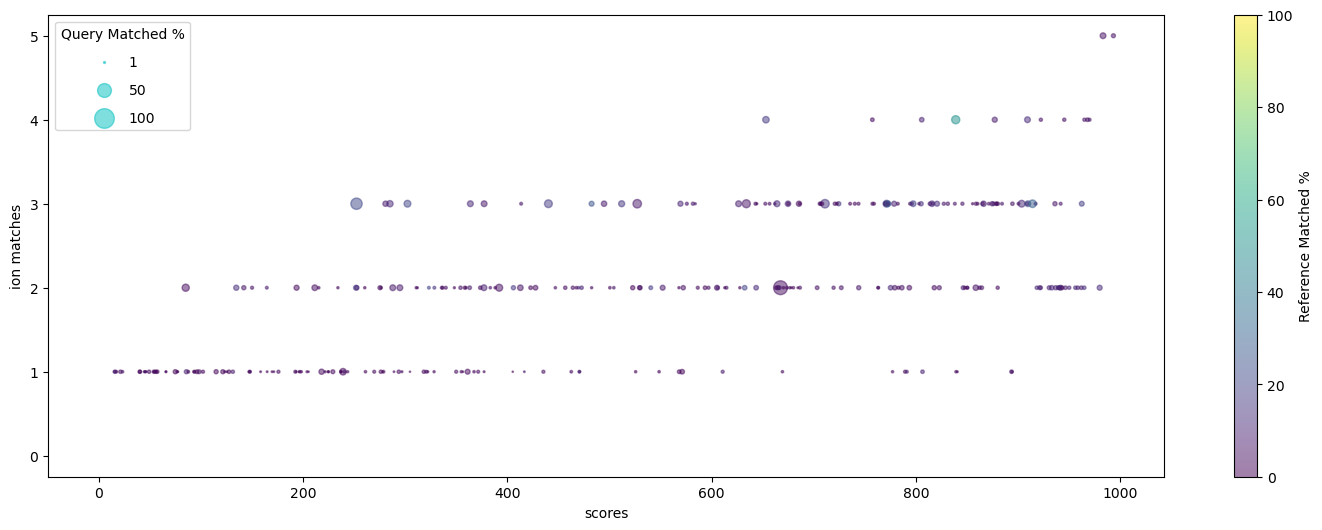

In [5]:
# Create a scatter plot
scatterplot_matplotlib(normalize_df(merged, matches_norm_col=None)).show()
